
# Projeto: Integração de Dados de Criminalidade e Meteorologia — Santa Rosa (2021–2025)

> **Notebook fiel ao escopo** (Etapas / Balões), com comentários prontos para apresentação e **3 gráficos** gerados no final.



## Escopo (Checklist de Balões)
- **Balão 1 — Coleta**: identificar & baixar datasets, organizar arquivos
- **Balão 2 — Concatenação**: importar & **concatenar** todos os anos de crimes
- **Balão 3 — Limpeza**: ausentes, **duplicatas**, **datas** (YYYY-MM-DD), padronização categórica
- **Balão 4 — Integração**: merge **crimes + meteo** por **data + cidade**
- **Balão 5 — Transformações**: categóricos → numéricos, **outliers (IQR)**, **normalização**
- **Balões 6..9 — Exploração e Storytelling**: **3 gráficos**, correlações, insight e apresentação


Lista de participantes:
Henrique Panisson Agostineto - 1136301
Fabricio Vecchi Panisson - 1134808

## Bloco 0 — Imports e Configurações (usado em todas as etapas)

In [6]:

import pandas as pd
import numpy as np
import unicodedata
from pathlib import Path

pd.set_option("display.max_columns", 160)

# === Parâmetros gerais ===
CIDADE_ALVO = "SANTA ROSA"
SEP = ";"
ENC = "latin1"
CHUNK = 100_000

ARQS_CRIMES = [
    "dados_criminais_2021.csv",
    "dados_criminais_2022.csv",
    "dados_criminais_2023.csv",
    "dados_criminais_2024.csv",
    "dados_criminais_2025.csv",
]
ARQ_METEO_ORIG = "dados_metereologicos_santa_rosa.csv"
ARQ_METEO_SAN  = "dados_metereologicos_santa_rosa_SAN.csv"
ARQ_CRIMES_SR  = "crimes_santa_rosa_2021_2025.csv"
ARQ_UNIFICADO  = "dataset_unificado_crime_meteo_santa_rosa.csv"


### Funções auxiliares (normalização e padronização de colunas)

In [7]:

def normalize_str(s):
    if pd.isna(s): return s
    s = str(s).strip().lower()
    s = ''.join(ch for ch in unicodedata.normalize('NFKD', s) if not unicodedata.combining(ch))
    s = ' '.join(s.split())
    return s

def standardize_crime_columns(df):
    rename_map = {}
    for c in df.columns:
        cn = normalize_str(c)
        if "municipio" in cn and "fato" in cn:
            rename_map[c] = "municipio_fato"
        elif cn in {"data_fato","data fato","data","dt","dia","date"} or "data" in cn:
            rename_map[c] = "data_fato"
        elif "natureza" in cn or "descricao" in cn or "tipo" in cn:
            rename_map[c] = "natureza"
        elif "bairro" in cn:
            rename_map[c] = "bairro"
        elif "boletim" in cn or cn.startswith("id"):
            rename_map[c] = "id_ocorrencia"
    if rename_map:
        df = df.rename(columns=rename_map)
    return df



## Etapa 1 — **Coleta de Dados** *(Balão 1)*
- Organizamos os **CSVs de criminalidade por ano** e o CSV de **meteorologia** em uma mesma pasta.
- **Meteo**: contém 10 linhas iniciais de cabeçalhos/ruído → **ignorar**.
- **Checkpoint**: lista de arquivos a serem usados.


In [8]:

print("Arquivos de crimes encontrados:")
for a in ARQS_CRIMES:
    print(" -", a, "| existe:", Path(a).exists())
print("\nArquivo de meteorologia:", ARQ_METEO_ORIG, "| existe:", Path(ARQ_METEO_ORIG).exists())


Arquivos de crimes encontrados:
 - dados_criminais_2021.csv | existe: True
 - dados_criminais_2022.csv | existe: True
 - dados_criminais_2023.csv | existe: True
 - dados_criminais_2024.csv | existe: True
 - dados_criminais_2025.csv | existe: True

Arquivo de meteorologia: dados_metereologicos_santa_rosa.csv | existe: True



## Etapa 2 — **Concatenação** *(Balão 2)*
- Importamos todos os anos de crimes (em **chunks** para poupar RAM).
- **Padronizamos** colunas (ex.: `municipio_fato`, `data_fato`, `natureza`).
- **Filtramos** apenas **Santa Rosa** e **salvamos** um CSV único: `crimes_santa_rosa_2021_2025.csv`.
- **Checkpoint**: dataframe único consolidado de crimes (apenas Santa Rosa).


In [9]:

from IPython.display import display
import gc

Path(ARQ_CRIMES_SR).unlink(missing_ok=True)
total_in, total_out = 0, 0
wrote_header = False

for arq in ARQS_CRIMES:
    if not Path(arq).exists():
        print(f"Aviso: {arq} não encontrado; pulando.")
        continue
    for chunk in pd.read_csv(arq, sep=SEP, encoding=ENC, chunksize=CHUNK, engine="python"):
        total_in += len(chunk)
        chunk = standardize_crime_columns(chunk)

        if "municipio_fato" not in chunk.columns:
            cand = [c for c in chunk.columns if "municip" in normalize_str(c)]
            if cand: chunk = chunk.rename(columns={cand[0]: "municipio_fato"})
        if "data_fato" not in chunk.columns:
            cand = [c for c in chunk.columns if "data" in normalize_str(c) or normalize_str(c) in {"dt","dia","date"}]
            if cand: chunk = chunk.rename(columns={cand[0]: "data_fato"})
        if "municipio_fato" not in chunk.columns or "data_fato" not in chunk.columns:
            continue

        aux = chunk.copy()
        aux["__municipio_norm__"] = aux["municipio_fato"].map(normalize_str).replace({"sta rosa":"santa rosa","santa  rosa":"santa rosa"})
        aux = aux[aux["__municipio_norm__"] == "santa rosa"]
        if aux.empty:
            del aux; continue

        aux["data_fato"] = pd.to_datetime(aux["data_fato"], errors="coerce", dayfirst=True)
        aux = aux.dropna(subset=["data_fato"])

        keep = ["data_fato","municipio_fato","natureza","bairro","id_ocorrencia"]
        keep = [c for c in keep if c in aux.columns]
        aux = aux[keep].copy()
        aux["municipio_fato"] = "SANTA ROSA"

        aux.to_csv(ARQ_CRIMES_SR, sep=SEP, encoding=ENC, index=False, mode='a', header=not wrote_header)
        wrote_header = True
        total_out += len(aux)

        del aux, chunk
        gc.collect()

print("Linhas lidas:", total_in, "| Linhas gravadas (Santa Rosa):", total_out)
print("Arquivo consolidado:", ARQ_CRIMES_SR, "| existe:", Path(ARQ_CRIMES_SR).exists())


Linhas lidas: 2768178 | Linhas gravadas (Santa Rosa): 19434
Arquivo consolidado: crimes_santa_rosa_2021_2025.csv | existe: True



## Etapa 3 — **Limpeza e Padronização** *(Balão 3)*
- **Valores ausentes**: remoção de linhas sem data; categóricas mantidas.
- **Duplicatas**: remoção por chaves (`data_fato`, `municipio_fato`, `natureza`, `bairro`, `id_ocorrencia` se existirem).
- **Datas**: formato **YYYY-MM-DD** garantido.
- **Checkpoint**: crimes de Santa Rosa limpos e consistentes.


In [10]:

crimes = pd.read_csv(ARQ_CRIMES_SR, sep=SEP, encoding=ENC, engine="python")
crimes["data_fato"] = pd.to_datetime(crimes["data_fato"], errors="coerce", dayfirst=True)
crimes = crimes.dropna(subset=["data_fato"]).copy()

keys = ["data_fato"]
for k in ["municipio_fato","natureza","bairro","id_ocorrencia"]:
    if k in crimes.columns: keys.append(k)
antes = len(crimes)
crimes = crimes.drop_duplicates(subset=keys)
print("Duplicatas removidas:", antes - len(crimes))
crimes.head()


Duplicatas removidas: 107


,data_fato,municipio_fato,natureza,natureza.1,bairro,id_ocorrencia
0,2021-01-10,SANTA ROSA,FURTO SIMPLES EM RESIDENCIA,Consumado,Cruzeiro,49.0
1,2021-01-10,SANTA ROSA,FURTO QUALIFICADO,Consumado,Timbaúva,51.0
2,2021-01-10,SANTA ROSA,VIAS DE FATO,Consumado,Sulina,39.0
3,2021-01-10,SANTA ROSA,AMEACA,Consumado,NaN,65.0
4,2021-01-10,SANTA ROSA,FURTO SIMPLES EM RESIDENCIA,Consumado,Cruzeiro,NaN



## Etapa 4 — **Integração com Meteorologia** *(Balão 4)*
- **Importamos** meteorologia **pulando 10 linhas** iniciais; garantimos **`;`** e **latin-1**.
- Ajustamos a coluna de **data** e criamos `cidade = SANTA ROSA`.
- **Coerção numérica** (vírgula decimal → ponto) e **preenchimento** de lacunas **apenas** em variáveis numéricas.
- **Merge** por `data + cidade`.
- **Checkpoint**: dataset unificado pronto para análise.


In [11]:

meteo_tmp = pd.read_csv(ARQ_METEO_ORIG, sep=SEP, encoding=ENC, skiprows=10, engine="python")
meteo_tmp.to_csv(ARQ_METEO_SAN, index=False, sep=SEP, encoding=ENC)

meteo = pd.read_csv(ARQ_METEO_SAN, sep=SEP, encoding=ENC, engine="python", decimal=',')
possiveis = [c for c in meteo.columns if ("data" in c.lower()) or (c.lower() in {"dt","date","dia"})]
col_data_meteo = possiveis[0] if possiveis else meteo.columns[0]

meteo[col_data_meteo] = pd.to_datetime(meteo[col_data_meteo], errors="coerce", dayfirst=True)
meteo["cidade"] = CIDADE_ALVO

num_cols_meteo = [c for c in meteo.columns if c not in {col_data_meteo,"cidade"}]
for c in num_cols_meteo:
    meteo[c] = (meteo[c].astype(str).str.replace(".","",regex=False).str.replace(",",".",regex=False))
    meteo[c] = pd.to_numeric(meteo[c], errors="coerce")

meteo = meteo.dropna(subset=[col_data_meteo]).copy().sort_values(col_data_meteo)

# crimes por dia
crimes_dia = crimes.groupby("data_fato", as_index=False).size().rename(columns={"size":"crimes_total"})
crimes_dia["cidade"] = CIDADE_ALVO
crimes_dia = crimes_dia.rename(columns={"data_fato":"data"})
meteo = meteo.rename(columns={col_data_meteo:"data"})

df = crimes_dia.merge(meteo, on=["data","cidade"], how="left")

met_cols = [c for c in meteo.columns if c not in {"data","cidade"}]
num_cols = df[met_cols].select_dtypes(include="number").columns
for c in num_cols:
    df[c] = df[c].fillna(df[c].mean())
print("Unificado:", df.shape)
df.head()


Unificado: (552, 9)


,data,crimes_total,cidade,Unnamed: 1,Unnamed: 2,Unnamed: 3,61,Unnamed: 5,Unnamed: 6
0,2021-01-10,16,SANTA ROSA,1.788462,27.090909,15.92,75.404762,1.956522,NaN
1,2021-01-11,11,SANTA ROSA,1.788462,27.090909,15.92,75.404762,1.956522,NaN
2,2021-01-12,15,SANTA ROSA,1.788462,31.000000,15.92,75.404762,1.956522,NaN
3,2021-02-10,18,SANTA ROSA,1.788462,27.090909,16.00,75.404762,1.956522,NaN
4,2021-02-11,17,SANTA ROSA,1.788462,27.090909,15.92,75.404762,1.956522,NaN



## Etapa 5 — **Transformações** *(Balão 5)*
- **Outliers (IQR)**: winsorization por Q1−1.5·IQR / Q3+1.5·IQR.
- **Normalização**: **Min-Max** para comparabilidade (`*_scaled`).  
- **Checkpoint**: dataset final tratado.


In [12]:

num_all = df.select_dtypes(include=[np.number]).columns.tolist()

for c in num_all:
    q1, q3 = df[c].quantile([0.25,0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    df[c] = df[c].clip(lower=low, upper=high)

for c in num_all:
    mn, mx = df[c].min(), df[c].max()
    if mx > mn:
        df[c + "_scaled"] = (df[c] - mn) / (mx - mn)

print("Transformações aplicadas.")


Transformações aplicadas.



## Etapa 6 — **Exploração e Descoberta** *(Balões 6..9)*
**Pergunta**: Há **tendência** entre condições climáticas e **crimes por dia**?  
Geramos **3 gráficos** e calculamos **correlações** para fundamentar a conclusão.


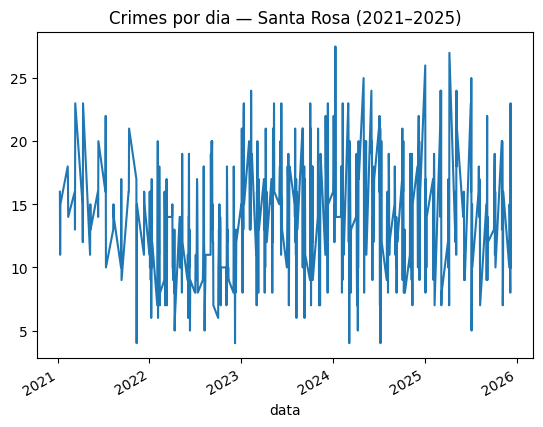

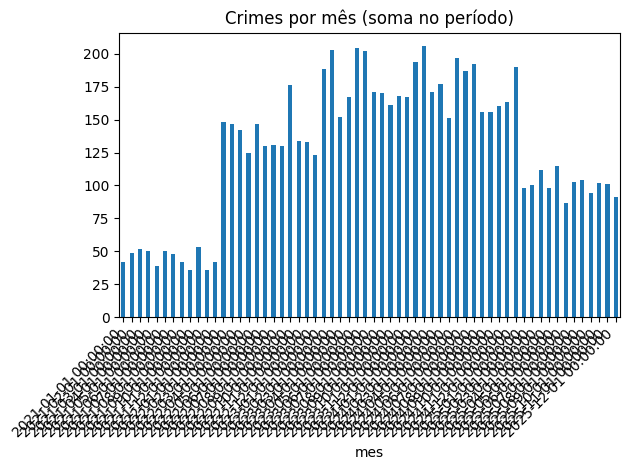

Não foi possível identificar variável climática com correlação suficiente neste dataset.


In [13]:

import matplotlib.pyplot as plt

# Gráfico 1 — Série temporal
plt.figure()
df.sort_values("data").set_index("data")["crimes_total"].plot(title="Crimes por dia — Santa Rosa (2021–2025)")
plt.show()

# Gráfico 2 — Sazonalidade mensal
plt.figure()
mensal = df.copy()
mensal["mes"] = pd.to_datetime(mensal["data"]).dt.to_period("M")
mensal = mensal.groupby("mes")["crimes_total"].sum()
mensal.index = mensal.index.to_timestamp()
mensal.plot(kind="bar", title="Crimes por mês (soma no período)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Gráfico 3 — Dispersão com a variável climática mais correlacionada
meteo_prefixos = ("temp","vento","chuva","precip","umid","press","radiacao","sensacao")
cand = [c for c in df.columns if c.startswith(meteo_prefixos)]
cand = [c for c in cand if pd.api.types.is_numeric_dtype(df[c])]
corr = df[cand + ["crimes_total"]].corr(numeric_only=True)
target = None
if "crimes_total" in corr.columns and len(corr.columns)>1:
    target = corr["crimes_total"].drop(labels=["crimes_total"]).abs().sort_values(ascending=False).index[0]

if target:
    plt.figure()
    plt.scatter(df[target], df["crimes_total"])
    plt.xlabel(target)
    plt.ylabel("Crimes por dia")
    plt.title(f"Crimes x {target}")
    plt.show()

# Correlações (top 10)
if target:
    print("\nCorrelação com crimes_total (topo por |r|):")
    display(corr["crimes_total"].dropna().sort_values(key=lambda s: s.abs(), ascending=False).head(10))

# Insight textual
if target:
    r = corr.loc[target, "crimes_total"]
    tendencia = "tendem a aumentar" if r>0 else "tendem a diminuir"
    print(f"\n**Insight:** crimes {tendencia} quando {target} está mais {'alto' if r>0 else 'baixo'} (r = {r:.3f}).")
else:
    print("Não foi possível identificar variável climática com correlação suficiente neste dataset.")


## Export — Dataset unificado (para a apresentação)

In [14]:

df.to_csv(ARQ_UNIFICADO, index=False, sep=SEP, encoding=ENC)
print("Salvo:", ARQ_UNIFICADO)


Salvo: dataset_unificado_crime_meteo_santa_rosa.csv
